In [125]:
# aideveloper
# Municipality Locator v1.0 - Find closest municipalities in the Philippines
import requests
import pandas as pd
import numpy as np
import folium
from fuzzywuzzy import fuzz

In [2]:
from OSMPythonTools.overpass import Overpass
ovp = Overpass()

In [3]:
import overpass
import geopandas as gpd
api = overpass.API()

In [4]:
import os
import json
import collections

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.plot import show
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [6]:
def search_municipalities(query):
    # Search OpenStreetMap for municipalities in the Philippines
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": f"{query}, Philippines",
        "format" : "json",
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        results = response.json()
        return results
    else:
        return None

In [7]:
def coastal_bld_cnt(municipality: dict, radius: int, shoredist: int):
    # Find number of local buildings near coast
    lat = municipality['lat']
    lon = municipality['lon']
    
    # formatted string using OSM overpass query language
    # - search for buildings within radius & store as '.a'
    # - search for coastline features within radius & store as '.b'
    # - search for buildings within '.a' that are within shoreline distance from features in '.b'
    # - return count (to conserve memory)
    qstring = f"way[\"building\"](around:{radius}, {lat}, {lon})->.a; way[\"natural\" = \"coastline\"](around:{radius}, {lat}, {lon})->.b; nwr.a(around.b:{shoredist}); (._;>;); out ids;"
    r = ovp.query(f"""
        {qstring}
    """)
    
    count = r.countWays()
    
    return count

In [8]:
def coastal_json(municipality:dict):
    lat = municipality['lat']
    lon = municipality['lon']
    radius = municipality['radius']
    shoredist = municipality['shoredist']
    
    # formatted string using OSM overpass query language
    # - search for buildings within radius & store as '.a'
    # - search for coastline features within radius & store as '.b'
    # - search for buildings within '.a' that are within shoreline distance from features in '.b'
    # - return count (to conserve memory)
    qstring = f"way[\"building\"](around:{radius}, {lat}, {lon})->.a; way[\"natural\" = \"coastline\"](around:{radius}, {lat}, {lon})->.b; nwr.a(around.b:{shoredist}); (._;>;); out geom;"

    r = api.get(f"""
        {qstring}
    """)
    
    return r

def coast_json(municipality:dict):
    lat = municipality['lat']
    lon = municipality['lon']
    radius = municipality['radius'] * 1.5
    
    # formatted string using OSM overpass query language
    # - search for buildings within radius & store as '.a'
    # - search for coastline features within radius & store as '.b'
    # - search for buildings within '.a' that are within shoreline distance from features in '.b'
    # - return count (to conserve memory)
    qstring = f"way[\"natural\" = \"coastline\"](around:{radius}, {lat}, {lon}); (._;>;); out geom;"

    r = api.get(f"""
        {qstring}
    """)
    
    return r

In [9]:
def east_west(municipality: dict, df: gpd.GeoDataFrame):
    city_lat = float(municipality['lat'])
    city_lon = float(municipality['lon'])

    bld_lat = df['latitude'].median()
    bld_lon = df['longitude'].median()

    lat_dif = city_lat-bld_lat
    lon_dif = city_lon-bld_lon

    diff = (lat_dif, lon_dif)

    magnitude = np.sqrt(sum(x ** 2 for x in diff))
    norm_tuple = tuple(round(x / magnitude, 4) for x in diff)
    
    return norm_tuple

In [10]:
def margin_calc(direction: tuple, max=0.03):
    pad = [0.005 for i in range(4)]
    listicle = [0 for i in range (4)]
    if direction[0]>0:
        listicle[0] = max*abs(direction[0])
    else:
        listicle[1] = max*abs(direction[0])
    if direction[1]>0:
        listicle[2] = max*abs(direction[1])
    else:
        listicle[3] = max*abs(direction[1])

    result = [pad[i]+listicle[i] for i in range(4)]
    return result


In [11]:
def choose_municipality():
    print("Philippines Locality Risk Exposures")
    # will automatically add ', Philippines' to query
    # include region for added precision
    while True:
        municipality_name = input("Enter the name of target municipality in the Philippines: ")
        # many buildings do not have address metadata, so we use search radius from town center
        distance_from_city = int(input("Building search radius (meters): "))
        distance_from_coast = int(input("Maximum distance from the coast (in m): "))

        # Search for municipalities
        municipalities = search_municipalities(municipality_name)

        if municipalities:
            print("Top 3 closest results:")
            count_buildings=[]
            for idx, result in enumerate(municipalities[:3]):
                # find number of relevant buildings to print
                bldg_count = coastal_bld_cnt(result, distance_from_city, distance_from_coast)
                count_buildings.append(bldg_count)
                print(f"Result {idx + 1}:")
                print(f"Display Name: {result['display_name']}")
                print(f"Latitude: {result['lat']}, Longitude: {result['lon']}, Coastal Buildings: {bldg_count}")
                print("-------------------")
        
            print("Enter 0 and revise search if desired result is not shown.")
            print("-------------------")
        
            while True:
                selection = int(input("Matching result (1-3)): "))
                if 1 <= selection <= 3:
                    selected_municipality = municipalities[selection - 1]
                    selected_municipality["building_count"] = count_buildings[selection - 1]
                    selected_municipality["radius"] = distance_from_city
                    selected_municipality["shoredist"] = distance_from_coast
                    break
                elif selection == 0:
                    print("Please revise search")
                    # return to beginning of function
                    break
                else:
                    print("Invalid selection. Please choose a number between 1 and 3.")
            break
        else:
            print("No results found for the given query. Check spelling and try again")

    return selected_municipality

In [12]:
out_dir = ""

In [13]:
def save_geojson(geoquery, city: dict): # save geojson.feature.FeatureCollection to file
    name = city['name']
    r = city['radius']
    s = city['shoredist']
    filename = f'{name}_osm_query_({r},{s}).GeoJSON'
    folder_path = f'./city files/{name}_({r},{s})'
    
    # if local folder f'{name}' exists, save GeoJSON locally
    if not os.path.exists(folder_path):
        # prompt if user wants to create a local output folder or select an output path
        create_folder = input(f"Folder '{name}' does not exist in 'city files' directory. Do you want to create it? (yes/no): ")
        if create_folder.lower().startswith('y'):
            os.makedirs(folder_path)
            filepath = f'{folder_path}/{filename}'
        else:
            # open a selction screen for a filepath
            custom_path = input("Please enter the desired output path: ")
            folder_path = custom_path
            filepath = f'{folder_path}/{filename}'
    else:
        filepath = f'{folder_path}/{filename}'
        # check if f'{folder_path}/{filename}' exists and confirm overwrite
        while os.path.exists(filepath):
            overwrite = input(f"'{filepath}' already exists. Overwrite? (yes/no): ")
            if overwrite.lower().startswith('y'):
                # delete old file
                os.remove(filepath)
            else:
                new_filename = input(f"Please choose a new filename (default: {filepath}): ")
                new_filepath = f'{folder_path}/{new_filename.strip()}'
                if new_filename != filename:
                    filepath = new_filepath
                    break
                else:
                    filepath = new_filepath
                              
    with open(filepath, 'w') as file:
        json.dump(geoquery, file)
    
    print(f'OSM query output saved to {filepath}')
    return folder_path

In [26]:
def find_box(value, sorted_ranges):
    iterations = len(sorted_ranges)
    lower_bounds = []
    upper_bounds = []
    for rng in sorted_ranges:
        lower_bounds.append(rng[0])
        upper_bounds.append(rng[1])
    for i in range(iterations):
        if lower_bounds[i] <= value <= upper_bounds[i]:
            return i
        else:
            continue
    return None

In [27]:
def find_boxrange(datalist, max_bins=5):
    datalist = sorted(datalist)
    percents = [(i+1) * (100/max_bins) for i in range(max_bins-1)]
    pct_edges = np.percentile(datalist, percents)
    ranges = [[] for i in range(max_bins)]
    ranges[0].append(min(datalist))
    for i in range(len(pct_edges)):
        num = pct_edges[i]
        ranges[i].append(num+0.5)
        ranges[i+1].append(num+0.5)
    ranges[-1].append(max(datalist))
    
    return ranges

In [28]:
def make_binlabels(datalist, ranges: list):
    iterations = len(ranges)
    first_val = str(next((x for x in datalist if x > ranges[0][1]), None))
    new_range = [[0,0,0] for i in range(iterations)]
    for i in range(1,iterations):
        if np.ceil(ranges[i][0])==np.floor(ranges[i][1]):
            new_range[i]= [str(int(np.ceil(ranges[i][0])))]
        else:
            new_range[i][0] = str(int(next((x for x in datalist if x > ranges[i-1][1]), '-')))
            new_range[i][1] = '-'
            new_range[i][2] = str(int(np.floor(ranges[i][1])))
    first_label = ''.join(['<',str(first_val)])
    last_label = ''.join([new_range[-1][0],'+'])
    labels = [''.join(new_range[i]) for i in range(1,iterations-1)]
    for i in range(len(labels)):
        labels[i] = new_range[i][0] if new_range[i][0] == new_range[i][0] else skip
    labels.insert(0, first_label)
    labels.append(last_label)

    return labels

In [14]:
# use 'choose_municipality' function to find desired city and output dict
city = choose_municipality()

Philippines Locality Risk Exposures
Enter the name of target municipality in the Philippines: santa lucia
Building search radius (meters): 5000
Maximum distance from the coast (in m): 400


[overpass] downloading data: [timeout:25][out:json];
        way["building"](around:5000, 17.1204469, 120.4491232)->.a; way["natural" = "coastline"](around:5000, 17.1204469, 120.4491232)->.b; nwr.a(around.b:400); (._;>;); out ids;
    


Top 3 closest results:


[overpass] downloading data: [timeout:25][out:json];
        way["building"](around:5000, 15.9554674, 120.5548882)->.a; way["natural" = "coastline"](around:5000, 15.9554674, 120.5548882)->.b; nwr.a(around.b:400); (._;>;); out ids;
    


Result 1:
Display Name: Santa Lucia, Ilocos Sur, Philippines
Latitude: 17.1204469, Longitude: 120.4491232, Coastal Buildings: 1131
-------------------


[overpass] downloading data: [timeout:25][out:json];
        way["building"](around:5000, 9.7020509, 118.7155115)->.a; way["natural" = "coastline"](around:5000, 9.7020509, 118.7155115)->.b; nwr.a(around.b:400); (._;>;); out ids;
    


Result 2:
Display Name: Santa Lucia, Pangasinan, Ilocos Region, 2428, Philippines
Latitude: 15.9554674, Longitude: 120.5548882, Coastal Buildings: None
-------------------
Result 3:
Display Name: Santa Lucia, Puerto Princesa, Mimaropa, Philippines
Latitude: 9.7020509, Longitude: 118.7155115, Coastal Buildings: 2632
-------------------
Enter 0 and revise search if desired result is not shown.
-------------------
Matching result (1-3)): 1


In [15]:
# use OSM api to download GeoJSON of relevant points of interest
query = coastal_json(city)
# convert GeoJSON to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(query['features'])
# export query output to local filepath
out_dir = save_geojson(query, city)

Folder 'Santa Lucia' does not exist in 'city files' directory. Do you want to create it? (yes/no): y
OSM query output saved to ./city files/Santa Lucia_(5000,400)/Santa Lucia_osm_query_(5000,400).GeoJSON


In [93]:
# convert geojson data types to osm id types
typemap = {
    'Point' : 'Node',
    'LineString' : 'Way',
}
gdf['type'] = gdf['geometry'].apply(lambda x: typemap.get(x.geom_type, None))

# create new DataFrame with house footprints only
blds = gdf[gdf['type'] == 'Way'].reset_index(drop=True).drop_duplicates()
blds = blds[~blds['geometry'].is_empty]
blds = blds.set_crs(epsg=4326)

blds_count = len(blds)
if blds_count == city['building_count']:
    print(f"DataFrame 'blds' created with {blds_count} buildings")
else:
    print(f"DataFrame 'blds' created with {blds_count} buildings, {city['building_count']} buildings expected")

DataFrame 'blds' created with 1131 buildings


In [88]:
# query OSM for nearby coastline data
coast = coast_json(city)
# convert to gdf
coast_gdf = gpd.GeoDataFrame.from_features(coast['features'])

coast_gdf['type'] = coast_gdf['geometry'].apply(lambda x: typemap.get(x.geom_type, None))

# create new DataFrame with house footprints only
coast_gdf = coast_gdf[coast_gdf['type'] == 'Way'].reset_index(drop=True).drop_duplicates()

In [89]:
# Define the URL for elevation data download
elevation_data_url = "https://data.humdata.org/dataset/d7f6e172-4433-4eb9-a96f-0524917eb11d/resource/2ca22e01-8ab7-4447-b565-653e93db55b0/download/phl_msk_alt.zip"

# Open *.grd raster file for elevation
elevation_filename = "PHL_msk_alt.vrt"

# Download and unzip the elevation data
elevation_zip_path = "elevation_data.zip"
# elevation_data_dir = "PHL_msk_alt"
if not os.path.exists(elevation_filename):
    download = requests.get(elevation_data_url)
    with open(elevation_zip_path, "wb") as zip_file:
        zip_file.write(download.content)
    os.system(f"unzip {elevation_zip_path}")

# Load elevation data using rasterio
# elevation_file_path = os.path.join(elevation_data_dir, elevation_filename)
elevation_data = rasterio.open(elevation_filename)

In [90]:
# Create a function to find the closest elevation match
def find_closest_elevation(point):
    row, col = elevation_data.index(point.x, point.y)
    return elevation_data.read(1, window=((row, row + 1), (col, col + 1)))[0][0]

In [94]:
# Add 'ele' column to 'blds' GeoDataFrame with elevation data
blds['ele'] = blds['geometry'].centroid.apply(find_closest_elevation)

/var/folders/4m/8llr_ht12t16kp7zbdgjzmvw0000gp/T/ipykernel_81944/3232993466.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  blds['ele'] = blds['geometry'].centroid.apply(find_closest_elevation)


In [97]:
# Add 'coordinates' column to blds GeoDataFrame according to centroid of buildings
blds['latitude'] = blds['geometry'].apply(lambda x: round(x.centroid.y, 4))
blds['longitude'] = blds['geometry'].apply(lambda x: round(x.centroid.x, 4))


In [169]:
def generate_hist(series, variable: str, units='', maxbins=5):
    ## Add histogram to sublot
    sort_data = sorted(series.astype(int).tolist())
    hist_data = []

    # parameters for histogram
    bin_limit = maxbins
    var = variable.title()
    if units != '':
        u = f'({units})'
    max_val = max(sort_data)
    min_val = min(sort_data)

    bin_boxes = find_boxrange(sort_data, bin_limit)
    bin_labels = make_binlabels(sort_data, bin_boxes)
    for x in sort_data:
        index = find_box(x, bin_boxes)
        hist_data.append(bin_labels[index])

    bin_count = len(set(hist_data))

    # Calculate the bin width to ensure integer bins
    #bin_width = max(1, (max_val - min_val) // bin_count)
    c = collections.Counter(hist_data)
    lbl = [i[0] for i in c.items()]
    hgt = [i[1] for i in c.items()]

    # Generate a histogram of building elevations
    plt.figure(figsize=(8, 6))
    plt.bar(lbl, hgt, color='blue', edgecolor='black', alpha=0.6)
    plt.xlabel(f"{var} {u}")
    plt.ylabel("Number of Buildings")
    plt.title(f"Building {var} Histogram")

    # Save the histogram locally
    histogram_image_path = f"{out_dir}/{var}_histogram.png"
    plt.savefig(histogram_image_path, dpi=300, bbox_inches='tight')

    # Display the charts
    return plt.show()

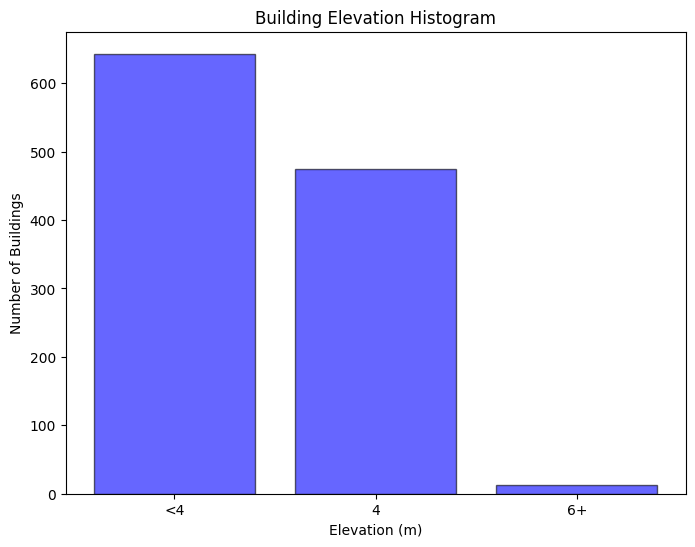

In [170]:
generate_hist(blds['ele'], 'elevation', 'm', 5)

/var/folders/4m/8llr_ht12t16kp7zbdgjzmvw0000gp/T/ipykernel_81944/4128713971.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('GnBu_r', len(unique_elevation_levels))


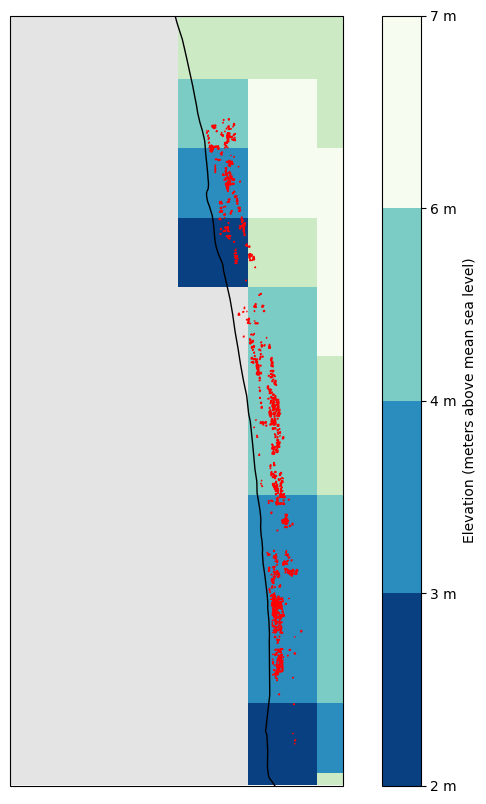

In [328]:
## Add shoreline map to subplots
# Create a figure and axis with Cartopy projection
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(10, 10))

#calculate bounds based on direction of coast
direc = east_west(city, blds)
pad = margin_calc(direc, max=0.02)
bounds= blds.total_bounds
ax.set_extent([bounds[0]-pad[2], bounds[2]+pad[3], bounds[1]-pad[0], bounds[3]+pad[1]])

# Read the data with a specified fill_value of 0 for ocean tiles
elevation_levels = elevation_data.read(1, window=elevation_data.window(*bounds), masked=True)

# Extract unique elevation levels
unique_elevation_levels = list(set(elevation_levels.filled(0).flatten().tolist()))

# Add contours from elevation data
color_map = plt.cm.get_cmap('GnBu_r', len(unique_elevation_levels))
color_map.set_bad(color='lightgray', alpha=.6)
show(elevation_data, ax=ax, cmap=color_map, alpha=1, vmin=min(unique_elevation_levels), vmax=max(unique_elevation_levels))

norm = mcolors.BoundaryNorm(boundaries=unique_elevation_levels, ncolors=color_map.N)

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)

# Set up the colorbar with custom labels
cbar = plt.colorbar(sm, ax=ax, ticks=unique_elevation_levels, format='%1.0f m')
cbar.set_label('Elevation (meters above mean sea level)')

# Add outlines for houses from GeoDataFrame
blds.plot(ax=ax, edgecolor='red', linewidth=1)
# Add coastline ways from Geodataframe
coast_gdf.plot(ax=ax, edgecolor='black', linewidth=1)

# Save the map locally
map_image_path = f"{out_dir}/coastal_elevation_map.png"
plt.savefig(map_image_path, dpi=300, bbox_inches='tight')

# Display the charts
plt.show()

In [102]:
# Change dataframe projection to a locally precise one.
blds_m = blds.to_crs(epsg=3123)
# New column for the area of 
blds_m['sqm'] = blds['geometry'].area

/var/folders/4m/8llr_ht12t16kp7zbdgjzmvw0000gp/T/ipykernel_81944/815077496.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  blds_m['sqm'] = blds['geometry'].area.apply(lambda x: x*1000)


In [171]:
# view and save histogram for area of buildings
generate_hist(blds_m['sqm'], 'area', 'sq m', 8)

ValueError: invalid literal for int() with base 10: '-'

In [33]:
# import municipality level data for construction materials
mcpl_fn = 'PSA_20_Cns_Mun_Mat.csv'
psa = pd.read_csv(mcpl_fn).iloc[:,2:]

In [158]:
def citymatch(city, df):
    name = city['display_name']
    bbox = [float(x) for x in city['boundingbox']]
    df['disp'] = df.apply(lambda x: ','.join([str(x['Municipality']), str(x['Region'])]), axis=1)
    
    # Find all rows in df for which df['Latitude'] and df['Longitude'] are within the bounding box
    #df_boxed = df[(bbox[0] <= df['Latitude']) & (df['Latitude'] <= bbox[1]) & 
    #              (bbox[2] <= df['Longitude']) & (df['Longitude'] >= bbox[3])]
    
    # Use fuzzywuzzy to match 'name' to the df_boxed['Municipalities'] column
    df['MatchScore'] = df['disp'].apply(lambda x: fuzz.token_sort_ratio(name, x))
    
    # Get the row with the highest matching score
    best_match = df[df['MatchScore'] == df['MatchScore'].max()]
    
    return best_match

In [163]:
matdf = citymatch(city, psa)
name = city['name']
matdf.to_csv(f'{out_dir}/{name}_constr_materials.csv')

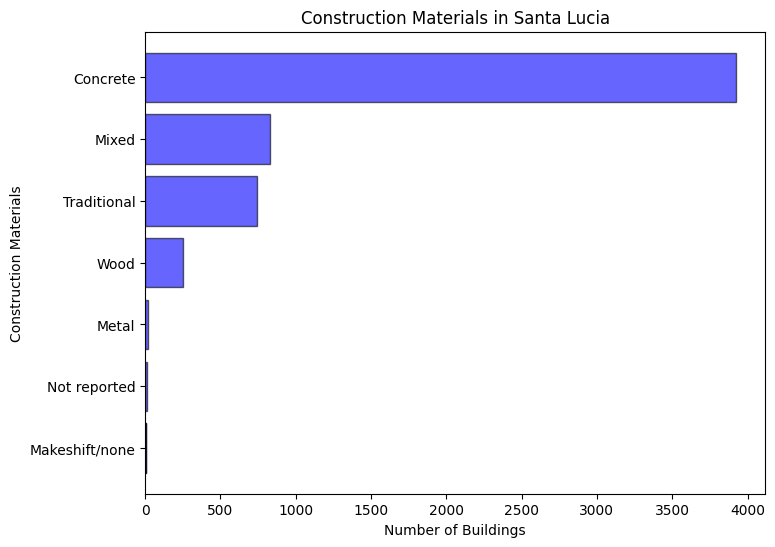

In [205]:
var = 'Construction Materials'

# create lists from the 'Materials Categories' and 'Total Occupied Housing Units' columns of matdf for a bar chart by sorting in descending order by the 'Total Occupied Housing Units' column and aggregating units for matching 'Material Categories' column and dropping any na values. 
subdf = matdf.dropna(subset=['Total Occupied Housing Units'])
lbl = subdf[subdf['Material Categories'] != 'Total'].sort_values(by='Total Occupied Housing Units', ascending=True)['Material Categories'].tolist()
hgt = subdf[subdf['Material Categories'] != 'Total'].sort_values(by='Total Occupied Housing Units', ascending=True)['Total Occupied Housing Units'].tolist()

# Generate a histogram of building elevations
plt.figure(figsize=(8, 6))
plt.barh(lbl, hgt, color='blue', edgecolor='black', alpha=0.6)
plt.ylabel(f"{var}")
plt.xlabel("Number of Buildings")
plt.title(f"{var} in {name}")

# Save the histogram locally
histogram_image_path = f"{out_dir}/{name}_{var}_histogram.png"
plt.savefig(histogram_image_path, dpi=300, bbox_inches='tight')

# Display the charts 
plt.show()

In [311]:
def assign_material(citydf, buildingsdf):
    # create a series with 
    count=len(buildingsdf)
    
    # ensure that building counts are not null
    df = citydf[psa['Construction Materials'] != 'Total']
    df['Total Occupied Housing Units'] = df['Total Occupied Housing Units'].fillna(0)
    
    # calculate probabilities for materials distributions
    total = df['Total Occupied Housing Units'].sum()
    probs = [units / total for units in df["Total Occupied Housing Units"]]
    
    mat_series = [np.random.choice(df['Material Categories'], p=probs) for i in range(count)]
    return mat_series

def assign_roof(citydf, buildingsdf):
    # check if buildingsdf['material'] exists
    if 'material' not in buildingsdf.columns:
        print("DataFrame['material'] does not exist. Please run assign_material first.")
        return
    
    # Ensure no null values
    citydf = citydf.fillna(0)
    
    # Group by 'Material Categories' and sum numerical values
    citydf = citydf.groupby('Material Categories').sum()
    
    roof_materials = ['Roof: Galvanized iron/aluminum',
       'Roof: Tile/concrete/clay tile',
       'Roof: Half galvanized iron and half concrete',
       'Roof: Bamboo/cogon/ nipa/anahaw', 'Roof: Asbestos',
       'Roof:Makeshift/ salvaged/ improvised materials', 'Roof:Trapal',
       'Roof: Others', 'Roof: Not Reported']
    
    # Assign probabilities to each roof material depending on construction material
    for idx, row in citydf.iterrows():
        total = row['Total Occupied Housing Units']
        if total != 0:
            for mat in roof_materials:
                row[mat] /= total
        else:
            for mat in roof_materials:
                row[mat] =0
    for idx, row in buildingsdf.iterrows():
        x = row['material']
        c = np.random.multinomial(1, citydf.loc[x][roof_materials]).argmax()
        row['roof material'] = citydf.loc[x][roof_materials[c]]
    
    return buildingsdf

In [216]:
blds['material'] = assign_material(matdf, blds)

[0.6766177739430543, 0.043830888697152716, 0.14288179465056083, 0.003451251078515962, 0.12873166522864538, 0.0006902502157031924, 0.0, 0.0012079378774805867, 0.0003451251078515962, 0.0, 0.0, 0.0022433132010353752]


/var/folders/4m/8llr_ht12t16kp7zbdgjzmvw0000gp/T/ipykernel_81944/3191931877.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = citydf[psa['Construction Materials'] != 'Total']
/var/folders/4m/8llr_ht12t16kp7zbdgjzmvw0000gp/T/ipykernel_81944/3191931877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total Occupied Housing Units'] = df['Total Occupied Housing Units'].fillna(0)


In [312]:
# roof material assignment not working due to rounding errors with numpy.random
# blds = assign_roof(matdf, blds)

ValueError: pvals < 0, pvals > 1 or pvals contains NaNs

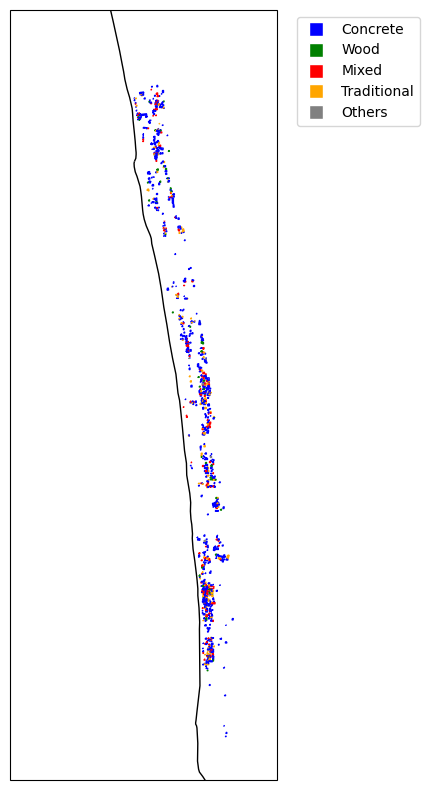

In [327]:
# map of buildings with possible illustration of materials

# Create a figure and axis with Cartopy projection
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(10, 10))

#calculate bounds based on direction of coast
direc = east_west(city, blds)
pad = margin_calc(direc, max=0.01)
bounds= blds.total_bounds
ax.set_extent([bounds[0]-pad[2], bounds[2]+pad[3], bounds[1]-pad[0], bounds[3]+pad[1]])

colormap = {'Concrete': 'blue',
            'Wood': 'green',
            'Mixed': 'red',
            'Traditional': 'orange',
            'Others': 'gray',
            'Makeshift/none': 'gray',
            'Metal': 'gray',
            'Mixed': 'red',
            'Not reported': 'gray',
            'Others': 'gray',
            'Total': 'gray',
           }
shortmap = {'Concrete': 'blue',
            'Wood': 'green',
            'Mixed': 'red',
            'Traditional': 'orange',
            'Others': 'gray',
           }

# Add outlines for houses from GeoDataFrame
blds.plot(ax=ax, edgecolor=blds['material'].map(colormap), linewidth=1)
# Add coastline ways from Geodataframe
coast_gdf.plot(ax=ax, edgecolor='black', linewidth=1)

plt.legend(handles=[plt.Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in shortmap.items()], 
           bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the map locally
map_image_path = f"{out_dir}/coastal_materials_map.png"
plt.savefig(map_image_path, dpi=300, bbox_inches='tight')

# Display the charts
plt.show()